In [288]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

### Reading Image

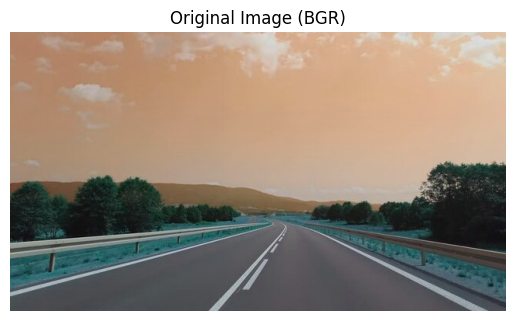

In [289]:
bgr = cv.imread('Road03.png') 
plt.imshow(bgr)
plt.title("Original Image (BGR)")
plt.axis('off')
plt.show()

### Converting BGR to RGB

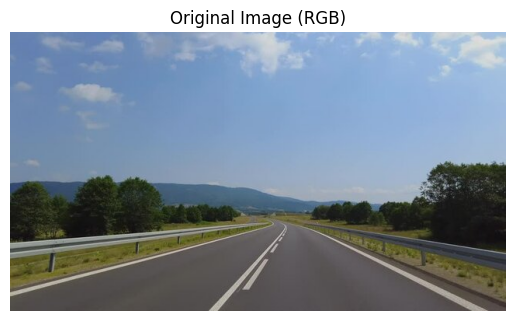

In [290]:
rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.title("Original Image (RGB)")
plt.axis('off')
plt.show()

### Convert RGB to Gray Scale

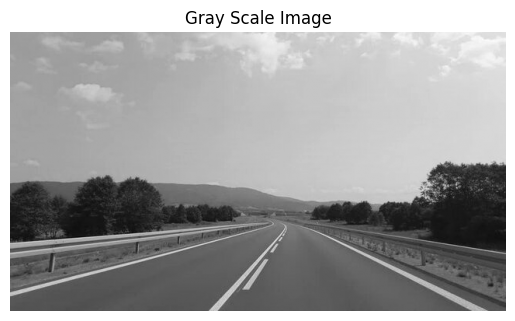

In [291]:
gray = cv.cvtColor(rgb, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")
plt.title("Gray Scale Image")
plt.axis('off')
plt.show()

#### Applying Median Filter

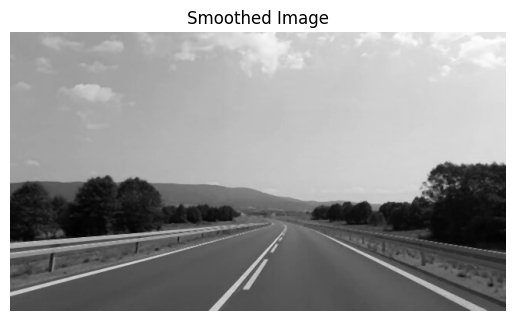

In [292]:
smoothed = cv.medianBlur(gray, 3)
plt.imshow(smoothed, cmap="gray")
plt.title("Smoothed Image")
plt.axis('off')
plt.show()

### Applying Canny's Edge Detector

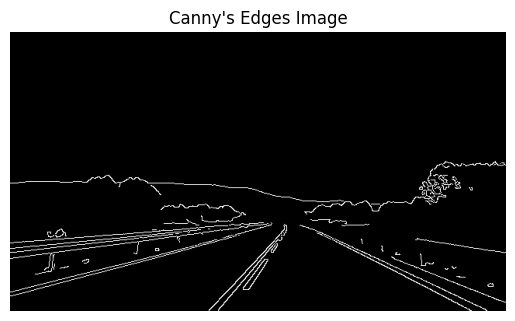

In [293]:
canny = cv.Canny(smoothed, 100, 200)
plt.imshow(canny, cmap='gray')
plt.title("Canny's Edges Image")
plt.axis('off')
plt.show()

### Creating the mask of ROI

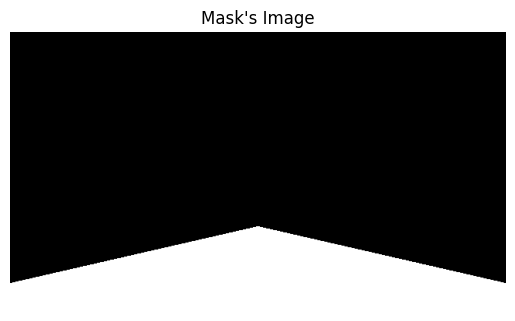

In [294]:
h, w = canny.shape
#v = np.array([[
#    (0, h),
#    (0, int(0.65 * h)),
#    (int(0.55 * w), int(0.45 * h)),
#    (w, int(0.8 * h)),
#    (w, h)
#]])

v = np.array([[
    (0, h),
    (0, int(0.9 * h)),
    (int(0.5 * w), int(0.7 * h)),
    (w, int(0.9 * h)),
    (w, h)
]])

mask = np.zeros_like(canny)
cv.fillPoly(mask, v, 255)
plt.imshow(mask,  cmap='gray')
plt.title("Mask's Image")
plt.axis('off')
plt.show()

### Applying the mask to the image

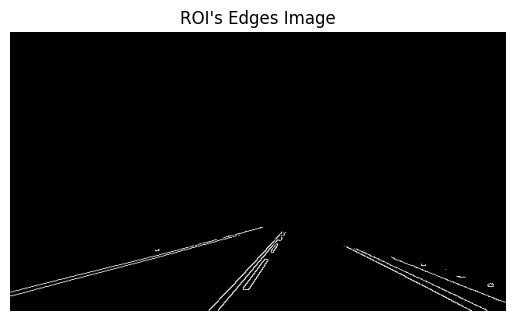

In [295]:
roi = cv.bitwise_and(canny, mask)
plt.imshow(roi, cmap='gray')
plt.title("ROI's Edges Image")
plt.axis('off')
plt.show()

### Hough Parameters

In [296]:
thetas = np.deg2rad(np.arange(0, 180))
cos_thetas, sin_thetas = np.cos(thetas), np.sin(thetas)

In [297]:
h, w = roi.shape
max_rho = int(np.hypot(h, w))
rhos = np.arange(-max_rho, max_rho + 1, 1) 

### Computing the Hough Accumulator

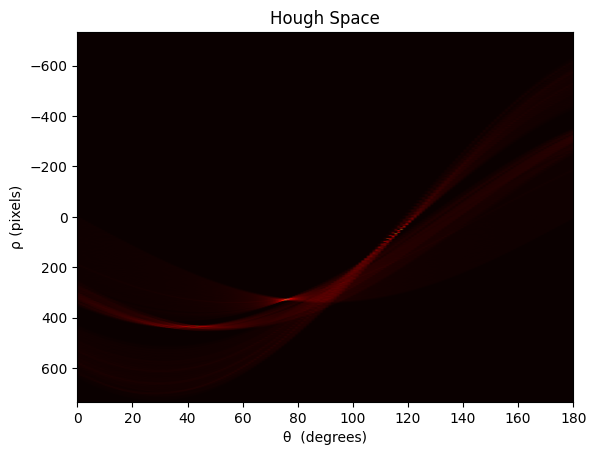

In [298]:
accumulator = np.zeros((len(rhos), len(thetas)))
edge_y, edge_x = np.nonzero(roi)
for x, y in zip(edge_x, edge_y):
    for idx in range(len(thetas)):
        rho = int(round(x * cos_thetas[idx] + y * sin_thetas[idx])) + max_rho
        accumulator[rho, idx] += 1

plt.imshow(accumulator, cmap="hot", aspect="auto", extent=[0, 180, rhos[-1], rhos[0]])
plt.title("Hough Space")
plt.xlabel("θ  (degrees)")
plt.ylabel("ρ (pixels)")
plt.show()

### Applying Threshold and Non-Maximum Suppression

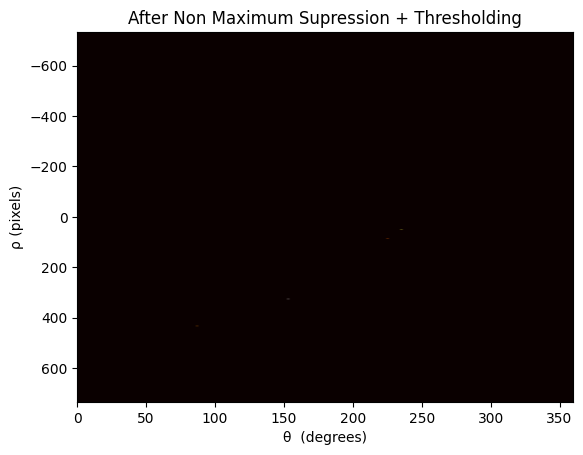

In [299]:
accumulator_nms = accumulator.copy()
accumulator_nms[accumulator_nms < 80] = 0

half_window = 20
for i in range(half_window, accumulator_nms.shape[0] - half_window):
    for j in range(half_window, accumulator_nms.shape[1] - half_window):
        window = accumulator_nms[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1]
        if accumulator_nms[i, j] != np.max(window):
            accumulator_nms[i, j] = 0

plt.imshow(accumulator_nms, cmap="hot", aspect='auto', extent=[0, 360, rhos[-1], rhos[0]])
plt.title("After Non Maximum Supression + Thresholding")
plt.xlabel("θ  (degrees)")
plt.ylabel("ρ (pixels)")
plt.show()

### Extracting Non-Zero Peaks

In [300]:
rhos_idx, thetas_idx = np.nonzero(accumulator_nms)
nonzero_points = sorted([(rhos[r], thetas[t], accumulator_nms[r, t]) 
                        for r, t in zip(rhos_idx, thetas_idx)], key=lambda x: x[2], reverse=True)

print(len(nonzero_points))

4


### Drawing detected lines within the ROI

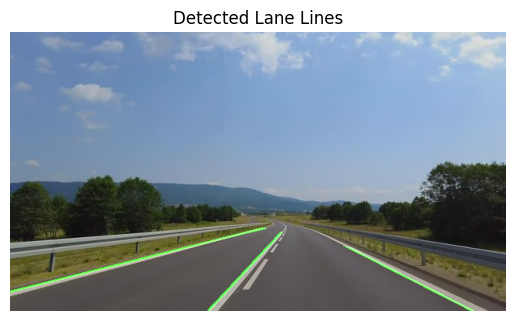

In [301]:
lines = np.zeros_like(rgb)
k = 3
for rho, theta, votes in nonzero_points[:k]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv.line(lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

lines_in_roi = cv.bitwise_and(lines, lines, mask=mask)
final_image = cv.bitwise_or(rgb.copy(), lines_in_roi)
plt.imshow(final_image)
plt.title("Detected Lane Lines")
plt.axis("off")
plt.show()